In [3]:
'''
__author__ = 'Alex Cheng'
Python集成方法工具包解决回归问题
ensemble.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score,mean_squared_error
from math import sqrt
import random

In [4]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
"wine-quality/winequality-red.csv")
df = pd.read_csv(target_url,header=0,sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
# 原始数组
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
names = df.columns

# RandomForest 要求数据为np.array格式
x = np.array(df.iloc[:,:-1])
y = np.array(labels)
wineNames = np.array(names)

# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# model_selection
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.30,random_state=828)

# 训练Gradient Boosting model 最小化均方误差
nEst = 200
depth = 7
learnRate = 0.01
subSamp = 0.5

wineGB = ensemble.GradientBoostingRegressor(n_estimators=nEst,max_depth=depth,
            learning_rate=learnRate,subsample=subSamp,loss='ls')
wineGB.fit(xTrain,yTrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The index of min error:  198
Min MSE with Boosting treeDepth 7 maxTree 200 : 0.3428074251941915


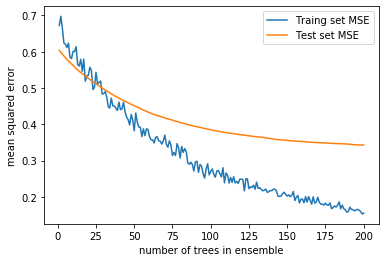

In [40]:
# 计算测试集的mse
mse = []
# staged_predict根据梯度提升法生成一些列模型，然后根据模型产生一系列的预测值，
# 每次都会利用梯度提升法在已产生的一系列模型中增加一个决策树，然后产生一个预测值
# 回归: staged_predict, 分类：staged_decision_fundtion
pred = wineGB.staged_predict(xTest)
for p in pred:
    mse.append(mean_squared_error(yTest,p))
#print(len(mse))
#print("min MSE: ", min(mse))
print("The index of min error: ",mse.index(min(mse)))
print('Min MSE with Boosting treeDepth',treeDepth,'maxTree',numTreeMax, ":", min(mse))

# 训练集的错误 vs 树的数量
plt.figure()
plt.plot(range(1,nEst+1), wineGB.train_score_, label='Traing set MSE')
plt.plot(range(1,nEst+1), mse,                 label='Test set MSE')
plt.legend(loc='upper right')
plt.xlabel("number of trees in ensemble")
plt.ylabel('mean squared error')
plt.show()


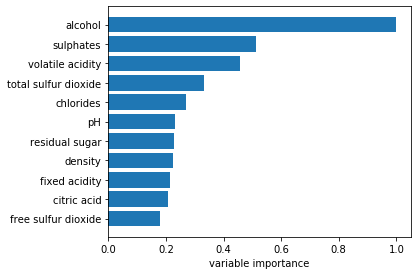

In [28]:
# 特征重要性
featImportance = wineGB.feature_importances_
featImportance = featImportance / featImportance.max()
idxSorted = np.argsort(featImportance)
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos,featImportance[idxSorted], align='center') # 水平柱状图
plt.yticks(barPos, wineNames[idxSorted])
plt.xlabel('variable importance')
plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1)
plt.show()


100
The index of min error:  96
Min MSE with Bagging treeDepth 7 maxTree 100 : 0.3546925169928963


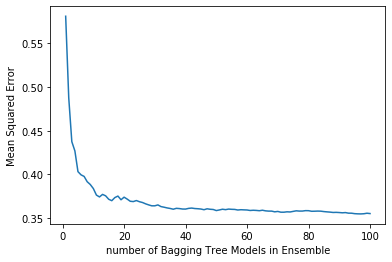

In [45]:
# Bagging模型和上面的Boosting对比
numTreeMax = 100
treeDepth = 7
modelList = []
predList = []

nBagSamples = int(len(xTrain) * .5)

# bootstrap抽样的决策树模型
for iTree in range(numTreeMax):
    idxBag = []
    # 每次不同的采样,以下是没有放回的
    #idxBag = random.sample(range(len(xTrain)),range(nBagSamples))
    # Bag是有放回的, 所以random.chioce
    for i in range(nBagSamples):
        idxBag.append(random.choice(range(len(xTrain))))
    
    xSample = [xTrain[i] for i in idxBag]
    ySample = [yTrain[i] for i in idxBag]
    modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
    modelList[-1].fit(xSample,ySample)
    
    latestPred = modelList[-1].predict(xTest) # 每个模型的预知
    predList.append(list(latestPred))
print(len(predList))

# 前n个决策树模型的累计
allPred = []
mse = []
for iModel in range(len(modelList)): # 注意，不要有0棵树的
    modelPred = []
    for iTest in range(len(xTest)):
        pred = sum([predList[i][iTest] for i in range(iModel+1 )]) / (iModel + 1) # 前iModel个树，对第iTest个测试数据的预测平均值
        modelPred.append(pred)
    allPred.append(modelPred)
    #print(len(allPred),len(allPred[0]))
    
    # 检查错误
    errors = [allPred[iModel][j] - yTest[j] for j in range(len(xTest))]
    mse.append(sum([e * e for e in errors]) / len(yTest))
print("The index of min error: ",mse.index(min(mse)))

nModels = [i+1 for i in range(len(modelList))]
plt.plot(nModels,mse)
plt.axis('tight')
plt.xlabel('number of Bagging Tree Models in Ensemble')
plt.ylabel('Mean Squared Error')
#plt.ylim(0.0,max(mse))
print('Min MSE with Bagging treeDepth',treeDepth,'maxTree',numTreeMax, ":", min(mse))
plt.show() 
